In [21]:
# ===============================================
# Video Stutter Detection Notebook
# このノートブックは動画のカクつき（stutter）を検出・解析するための最終段階のコード
# 実行環境（カーネル）はTestProg_video（Python 3.8.19）で行ってください
#
# ■メモ
# 改善確が終わったら、バージョンアップする。
#
# v0.0.2での対応
# カクツキ検知に重複動作（逐次カクツキ検知とキャプチャ終了後の全フレーム解析）があるのを修正→対応済み
# 差分が小さい場合の時間が短すぎる場合カクツキから除外がうまく動作してない→対応済み
# バックグラウンドワーカー付き 逐次自動閾値カクつき検知（CSVログ出力付き）を追加→対応済み
# 一時フォルダの画像がワンフレームおきに止まってる？だぶつく→対応済み（保存処理を別にさせる）→一時保管はやはりだぶつくけどグラフは改善してるのはなぜ？のこぎり波形になてない。だぶついてはいるけどコマ落ちはしてないから多くキャプチャし過ぎ？
# 動作は止まってないのに5分で止まってしまう。
# ===============================================

In [22]:
# ==========================================================
# 必要なライブラリのインポート（重複除去・カテゴリ別整理）
# ==========================================================

# --- 画像処理・数値計算 ---
import cv2                   # OpenCV: 動画読み込み・画像処理用
import numpy as np            # NumPy: 数値計算・配列処理用

# --- 可視化 ---
import matplotlib.pyplot as plt  # グラフ描画・可視化用

# --- GUI ---
import tkinter as tk             # GUI用
from tkinter import ttk          # GUI用（拡張ウィジェット）

# --- ファイル・システム操作 ---
import os                        # ファイルパス操作・環境操作
import shutil                    # ファイルコピー・削除
import csv                       # CSVファイル操作

# --- 並行処理 ---
import threading                 # マルチスレッド処理
import queue                     # スレッド間通信・キュー処理

# --- その他ユーティリティ ---
import time                      # 時間計測・待機
from datetime import datetime    # 日付・時刻操作
import gc                        # ガーベジコレクション操作
import re                        # 正規表現処理
import sys                       # システム関連（パス・終了処理など）

import pandas as pd
import matplotlib.pyplot as plt


In [23]:
# -----------------------------------------------
# list_video_devices 関数 (利用可能ビデオキャプチャデバイス一覧取得関数)
# -----------------------------------------------
"""
概要:
    接続されているビデオキャプチャデバイス（Webカメラなど）を探索し、
    利用可能なデバイス番号と識別名のリストを返す関数。
    この関数を使用することで、ユーザーが利用可能なカメラデバイスを選択可能になる。
    
引数:
    max_devices (int, optional): チェックする最大デバイス番号。デフォルトは10。
    timeout (float, optional): 各デバイスを試す際のタイムアウト秒数。デフォルトは1.0秒。
    
戻り値:
    devices (list of tuples): 利用可能なデバイスのリスト。
        例: [(0, 'Camera 0'), (1, 'Camera 1'), ...]
        
注意:
    - デバイスマネージャーで Trifora など特定ドライバを使用している場合、
      一部デバイスが正常に認識されないことがあります。
    - cv2.VideoCapture() は番号順にデバイスを開くため、
      接続順序によってデバイス番号が変わることがあります。
"""
def list_video_devices(max_devices=10, timeout=1.0):
    devices = []  # 利用可能なデバイスを格納するリスト

    # 内部関数：指定インデックスのデバイスが使用可能かチェック
    def try_open_device(idx, result_dict):
        try:
            # Windows向けに DirectShow 経由でデバイスをオープン
            cap = cv2.VideoCapture(idx, cv2.CAP_DSHOW)

            # 開けたかを確認
            if cap.isOpened():
                result_dict["opened"] = True

            # デバイスを解放（リソースリーク防止）
            cap.release()

        except Exception as e:
            # エラーが発生した場合（存在しない or ドライバエラーなど）
            print(f"デバイス {idx} は無視されました: {e}")
            result_dict["opened"] = False

    # 0 〜 max_devices-1 まで順にデバイスをチェック
    for idx in range(max_devices):
        result = {"opened": False}  # チェック結果を格納する辞書

        # スレッドを生成し、非同期でデバイスをオープンしてみる
        t = threading.Thread(target=try_open_device, args=(idx, result))
        t.start()

        # 指定時間だけスレッドの完了を待機（ハング防止）
        t.join(timeout=timeout)

        if t.is_alive():
            # タイムアウトを超えても応答がない場合
            print(f"デバイス {idx} はタイムアウト ({timeout} 秒) によりスキップされました")
        elif result["opened"]:
            # 正常に開けたデバイスを一覧に追加
            devices.append((idx, f"Camera {idx}"))

    return devices

# -----------------------------------------------
# 実行例（このファイルを直接実行した場合のみ動作）
# -----------------------------------------------
if __name__ == "__main__":
    print("利用可能なビデオキャプチャデバイス:")
    devices = list_video_devices(max_devices=10, timeout=1.0)

    # 検出されたカメラの一覧を出力
    for idx, name in devices:
        print(f"デバイス番号: {idx}, 名前: {name}")


利用可能なビデオキャプチャデバイス:
デバイス番号: 0, 名前: Camera 0
デバイス番号: 1, 名前: Camera 1


In [24]:
# -----------------------------------------------
# launch_gui 関数 (ビデオデバイス選択GUI関数)
# -----------------------------------------------
"""
概要:
    ユーザーが接続されているビデオキャプチャデバイスの中から
    1つを選択できるシンプルなGUIを表示し、
    選択されたデバイス番号を返す関数。

引数:
    devices (list of tuples):
        list_video_devices() などで取得した利用可能なデバイスのリスト。
        例: [(0, 'Camera 0'), (1, 'Camera 1'), ...]

戻り値:
    int or None:
        - ユーザーが「開始」ボタンを押した場合 → 選択されたデバイス番号を返す
        - GUIを閉じた、または何も選ばなかった場合 → None を返す

注意:
    - combo.current(0) により、デフォルトで最初のデバイスが選択される。
    - GUIを閉じただけで何も選ばなかった場合は None が返る。
    - tkinter は標準ライブラリのため、追加インストールは不要。
"""
def launch_gui(devices):
    selected_device = {"idx": None}  # 辞書で選択結果を共有（クロージャ内で参照できるようにする）

    # --------------------------------------------
    # GUI ウィンドウの基本設定
    # --------------------------------------------
    root = tk.Tk()                     # メインウィンドウ作成
    root.title("デバイス選択")          # ウィンドウタイトル設定
    root.geometry("300x150")           # ウィンドウサイズ（任意）
    root.resizable(False, False)       # サイズ変更を禁止

    # ラベル表示
    tk.Label(root, text="使用するデバイスを選択:").pack(pady=5)

    # --------------------------------------------
    # コンボボックス（デバイス一覧表示）
    # --------------------------------------------
    # 表示用に "Camera 0 (番号: 0)" のような文字列リストを生成
    display_names = [f"{name} (番号: {idx})" for idx, name in devices]

    device_var = tk.StringVar()  # コンボボックスの選択値を保持する変数

    # ttk.Combobox：選択式のプルダウンリスト
    combo = ttk.Combobox(
        root,
        textvariable=device_var,
        values=display_names,
        state="readonly"  # 編集不可（選択のみ）
    )
    combo.current(0)  # デフォルトで最初の項目を選択
    combo.pack(pady=5)

    # --------------------------------------------
    # 「開始」ボタンの動作定義
    # --------------------------------------------
    """
    「開始」ボタン押下時の処理。
    現在選択されている項目のインデックスからデバイス番号を取得し、
    それを共有辞書 selected_device に格納してウィンドウを閉じる。
    """
    def on_start():
        selected_device["idx"] = devices[combo.current()][0]
        root.destroy()  # GUIを閉じる（mainloopを終了）

    # ボタンの作成と配置
    tk.Button(root, text="開始", command=on_start).pack(pady=10)

    # --------------------------------------------
    # GUI メインループ開始（ここで処理が一時停止し、ユーザー操作を待つ）
    # --------------------------------------------
    root.mainloop()

    # 閉じた後、選択されたデバイス番号を返す（選択なしなら None）
    return selected_device["idx"]

In [25]:
# ====================================================
# 🔒 safe_rmtree 関数（安全で完全なフォルダ削除関数 / Windows対応・再試行付き）
# ====================================================
"""
概要:
    指定したフォルダを安全に削除する関数。
    Windows環境でよく発生する「削除中にファイルロックやアクセス拒否で失敗する」ケースにも対応し、
    一定回数リトライを行いながら、フォルダとその中身を完全に削除する。

引数:
    folder_path (str): 削除対象のフォルダパス。
    retry (int, optional): 削除を再試行する回数。デフォルトは3回。
    wait (float, optional): 再試行の間隔（秒）。デフォルトは0.5秒。

動作:
    - 存在しないフォルダを指定した場合はスキップしてメッセージを表示。
    - フォルダ内の全ファイル・サブフォルダを逆順に削除（os.walk(topdown=False)）。
    - 削除進捗をコンソール上にバー表示（例: [##########----------] 50%）。
    - 削除中にエラーが発生した場合でも処理を継続し、最大 retry 回までリトライ。

戻り値:
    なし（処理結果は標準出力にメッセージとして表示）

注意:
    - 削除対象フォルダは **完全に消去** されるため、取り消しはできません。
    - フォルダが他のプロセスによって使用中の場合、一時的に削除が遅れる場合があります。
    - Windows特有の一時ロックを考慮して wait 秒待機後に再試行を行います。
"""
def safe_rmtree(folder_path: str, retry=3, wait=0.5):
    # -------------------------------
    # 存在チェック
    # -------------------------------
    if not os.path.exists(folder_path):
        print(f"🗑️ フォルダ不存在: {folder_path}")
        return

    # -------------------------------
    # 内部関数: フォルダ内の全要素を取得（下位から上位へ削除するため）
    # -------------------------------
    def get_all_entries(path):
        entries = []
        # topdown=False により、ファイル → サブフォルダ → 親フォルダ の順に削除可能
        for root, dirs, files in os.walk(path, topdown=False):
            # ファイルを追加
            entries.extend([os.path.join(root, f) for f in files])
            # ディレクトリを追加
            entries.extend([os.path.join(root, d) for d in dirs])
        return entries

    # -------------------------------
    # 削除処理本体
    # -------------------------------
    for attempt in range(retry):
        try:
            all_entries = get_all_entries(folder_path)
            total = len(all_entries)

            # サブフォルダ・ファイルが空ならフォルダ自体を削除
            if total == 0:
                os.rmdir(folder_path)
                print(f"🗑️ 完全削除済み: {folder_path}")
                return

            # 削除ループ（進捗付き）
            for i, entry in enumerate(all_entries, start=1):
                try:
                    if os.path.isfile(entry) or os.path.islink(entry):
                        os.remove(entry)  # ファイル or シンボリックリンク削除
                    elif os.path.isdir(entry):
                        os.rmdir(entry)   # 空フォルダ削除
                except Exception as e:
                    print(f"⚠ 削除失敗: {entry} → {e}")

                # ----------------------------------------
                # 進捗バー表示
                # ----------------------------------------
                pct = int(i / total * 100)
                bar_len = 30  # バーの長さ（文字数）
                filled = int(bar_len * pct / 100)
                sys.stdout.write(f"\r削除中: [{'#'*filled}{'-'*(bar_len-filled)}] {pct}%")
                sys.stdout.flush()

            # ----------------------------------------
            # 最後にフォルダ自体を削除
            # ----------------------------------------
            try:
                os.rmdir(folder_path)
            except Exception as e:
                print(f"\n⚠ フォルダ自体の削除失敗: {e}")
            else:
                print(f"\n🗑️ 完全削除済み: {folder_path}")
            break  # 成功したらループを抜ける

        except Exception as e:
            print(f"\n⚠ 削除中エラー: {e} → {wait}秒後に再試行 ({attempt+1}/{retry})")
            time.sleep(wait)
    else:
        # retry 回すべて失敗した場合
        print(f"❌ {folder_path} の削除に失敗しました。")


In [26]:
# ====================================================
# stutter_worker_auto_threshold_csv 関数
# バックグラウンドワーカー付き 逐次自動閾値カクつき検知（CSVログ出力付き）
# バックグラウンドワーカーが逐次フレーム差分＋自動閾値判定＋カクつきフレーム保存＋CSV出力を担当
# ====================================================
"""
概要:
    バックグラウンドでフレームを受け取り、逐次的にカクつき（stutter）を検知するワーカー関数。
    - フレーム間差分（非ゼロ画素数）に基づき自動閾値を算出。
    - 差分が閾値以下の連続フレームを「カクつき」と判定。
    - min_time_diff 未満の短いカクつきは除外。
    - 十分な長さのカクつきフレームは PNG として output_folder に保存。
    - フレーム差分値、閾値、カクつきフラグを threshold_log.csv に逐次記録。

引数:
    frame_queue (queue.Queue): メインスレッドから送られる (frame_index, frame_image) タプルのキュー。
    output_folder (str): カクつきフレーム保存先フォルダパス。存在しない場合は自動作成。
    stop_flag (threading.Event): ワーカー終了を通知するフラグ。
    fps (float, optional): キャプチャFPS。デフォルトは60。
    min_time_diff (float, optional): これ未満の短いカクつきは除外する秒数。デフォルト0.1秒。
    k (float, optional): 自動閾値算出用の係数。デフォルト2.0。

動作:
    - キューからフレームを取得し、グレースケールに変換。
    - 直前フレームとの差分を計算し、非ゼロ画素数を算出。
    - 最近100フレームの差分から平均と標準偏差を計算し、閾値 = 平均 - k*標準偏差 と設定。
    - 差分が閾値以下の場合、カクつきフレーム候補として一時リストに追加。
    - 連続カクつきが min_time_diff 未満の場合は破棄。
    - 十分な長さの連続カクつきの場合、最初のフレームを PNG として保存。
    - CSV に (frame_idx, frame_diff, threshold, stutter_flag) を逐次書き込み。
    - stop_flag が立つか、キューに None が入ると終了。

戻り値:
    なし（処理結果は output_folder 内の PNG と threshold_log.csv に保存）

注意:
    - min_time_diff 未満の短いカクつきは自動的に除外される。
    - CSV と PNG 保存は逐次行われるため、リアルタイム処理に対応。
    - 処理終了時には残った連続カクつきも min_time_diff 以上なら保存。
    - ワーカーはデーモンスレッドとして起動することを想定。
"""

def stutter_worker_auto_threshold_csv(frame_queue, output_folder, stop_flag, fps=60, min_time_diff=0.1, k=2.0):
    """
    バックグラウンドでフレームを受け取り、自動閾値による逐次カクつき検知を行うワーカー。
    計算した閾値とフレーム差分、キュー状態を CSV に記録します。
    min_time_diff 未満の短いカクつきは除外されます。
    """
    prev_gray = None
    diff_history = []
    min_frame_diff = int(min_time_diff * fps)  # カクつき判定に必要な最低フレーム数
    temp_stutter_indices = []

    os.makedirs(output_folder, exist_ok=True)
    log_file = os.path.join(output_folder, "threshold_log.csv")

    # CSV ヘッダー書き込み
    with open(log_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "time", "frame_idx", "frame_diff", "threshold", "stutter_flag", "queue_size", "queue_max"
        ])

    try:
        while not stop_flag.is_set():
            try:
                item = frame_queue.get(timeout=1)
            except queue.Empty:
                continue

            if item is None:
                frame_queue.task_done()
                break

            idx, frame = item
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # デフォルト値
            non_zero_count = 0
            threshold = 0
            stutter_flag = 0

            if prev_gray is not None:
                diff = cv2.absdiff(gray, prev_gray)
                non_zero_count = np.count_nonzero(diff)
                diff_history.append(non_zero_count)

                recent_diff = diff_history[-100:] if len(diff_history) >= 1 else [non_zero_count]
                threshold = max(np.mean(recent_diff) - k * np.std(recent_diff), 0)

                # カクつき判定
                if non_zero_count <= threshold:
                    temp_stutter_indices.append((idx, frame))
                    stutter_flag = 1
                else:
                    # 連続カクつきが min_frame_diff 未満なら除外
                    if 0 < len(temp_stutter_indices) < min_frame_diff:
                        temp_stutter_indices = []  # 短すぎるカクつきは破棄
                    elif len(temp_stutter_indices) >= min_frame_diff:
                        # 十分長いカクつきは最初のフレームを保存
                        first_idx, first_frame = temp_stutter_indices[0]
                        cv2.imwrite(os.path.join(output_folder, f"stutter_{first_idx:05d}.png"), first_frame)
                        temp_stutter_indices = []
                    stutter_flag = 0

            # CSV に逐次書き込み（queue 状態も追加）
            current_time = datetime.now().strftime("%H:%M:%S.%f")[:-3]
            with open(log_file, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    current_time,
                    idx,
                    non_zero_count,
                    threshold,
                    stutter_flag,
                    frame_queue.qsize(),
                    frame_queue.maxsize
                ])

            prev_gray = gray
            frame_queue.task_done()
            del gray, frame

    finally:
        # 最後に残ったカクつきフレームを保存（min_time_diff 以上なら）
        if len(temp_stutter_indices) >= min_frame_diff:
            first_idx, first_frame = temp_stutter_indices[0]
            cv2.imwrite(os.path.join(output_folder, f"stutter_{first_idx:05d}.png"), first_frame)

        print("✅ ワーカー終了: カクつきフレームと閾値ログ保存完了")
        gc.collect()

In [27]:
# -------------------------------------------------------
# save_worker 関数
# 非同期保存用ワーカー
# -------------------------------------------------------
"""
概要:
    非同期でフレームを保存するワーカー関数。
    メインスレッドから渡されたキューを監視し、到着したフレームを順次ディスクに保存する。
    キャプチャと保存処理を分離することで、メインスレッドの処理負荷を軽減し、
    プレビュー表示やフレームキューへの送信が滞らないようにする。

引数:
    save_queue (queue.Queue): メインスレッドから渡されるフレーム保存用キュー。
                              各アイテムは (frame_index, frame_image) のタプル。
                              終了時は None をキューに入れてワーカーを停止。
    folder_path (str): 保存先のフォルダパス。存在しない場合は事前に作成しておく必要あり。

動作:
    - 無限ループでキューを取得。
    - キューから None が来たらループを抜けて終了。
    - 各フレームを JPEG 形式で指定フォルダに保存。
    - 保存中に例外が発生しても処理を継続し、エラー内容を標準出力に表示。
    - 保存完了後、task_done() を呼び出してキュー管理を更新。

戻り値:
    なし（処理結果は標準出力にメッセージとして表示）

注意:
    - この関数はデーモンスレッドとして起動することを想定。
    - キューが空の間は待機状態となり、CPU負荷は低い。
    - JPEG保存時の例外処理は簡易的で、必要に応じてリトライやログ出力を追加可能。
"""
def save_worker(save_queue, folder_path, queue_log_file=None):
    """
    キューに渡されたフレームを非同期で保存。
    保存後にキューサイズをログに残す。

    Args:
        save_queue (queue.Queue): 保存対象フレームのキュー
        folder_path (str): 保存先フォルダ
        queue_log_file (str, optional): キュー状態を記録するCSVファイルパス
    """
    # キューログファイルをフォルダ内に作成する場合
    if queue_log_file is None:
        queue_log_file = os.path.join(folder_path, "queue_log.csv")

    # ログCSVのヘッダー作成
    try:
        with open(queue_log_file, "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["frame_idx", "queue_size", "queue_max"])
    except Exception as e:
        print(f"⚠ キューログヘッダー作成エラー: {e}")

    while True:
        item = save_queue.get()
        if item is None:
            save_queue.task_done()
            break

        idx, frame = item
        try:
            filename = os.path.join(folder_path, f"frame_{idx:05d}.jpg")
            cv2.imwrite(filename, frame)
        except Exception as e:
            print(f"⚠ フレーム保存エラー: {e}")

        # --- キューサイズログ ---
        try:
            qsize = save_queue.qsize()
            with open(queue_log_file, "a", newline="", encoding="utf-8") as f:
                writer = csv.writer(f)
                writer.writerow([idx, qsize, save_queue.maxsize])
        except Exception as e:
            print(f"⚠ キューログ保存エラー: {e}")

        save_queue.task_done()

In [28]:
# ====================================================
# start_capture_and_detect_worker 関数
# メインスレッドはキャプチャとプレビューのみで軽量、保存は非同期ワーカーで行う。
# ====================================================
"""
概要:
    メインスレッドでカメラ映像をキャプチャしながらプレビュー表示を行い、
    バックグラウンドワーカーで逐次自動閾値カクつき検知を行う関数。
    フレームの保存も非同期ワーカーで行うため、メインスレッドは軽量に保たれる。

引数:
    device_number (int, optional): 使用するカメラのデバイス番号。デフォルトは0。
    width (int, optional): キャプチャ解像度の幅。デフォルトは720。
    height (int, optional): キャプチャ解像度の高さ。デフォルトは480。
    capture_fps (float, optional): キャプチャフレームレート。デフォルトは60。
    display_fps (float, optional): プレビュー表示のフレームレート。デフォルトは10。
    min_time_diff (float, optional): ワーカーでのカクつき判定の最小時間差（秒）。デフォルト0.1。
    max_temp_frames (int, optional): 一時フォルダに保存する最大フレーム数。デフォルト36000。
    stop_no_diff_sec (float, optional): 一定時間変化がなければ自動終了する秒数。デフォルト300。
    k (float, optional): 自動閾値計算時の標準偏差倍率。デフォルト2.0。

動作:
    - デスクトップに temp_frames と stutter_frames フォルダを作成。
    - OpenCVでカメラを初期化し、解像度・FPSを設定。
    - 内部バッファを1に固定して古いフレーム遅延を防止。
    - 非同期保存ワーカーを起動して、フレームを temp_frames に保存。
    - カクつき検知用バックグラウンドワーカーを起動。
    - メインループでフレームを取得し、保存キュー・検知キューに送信。
    - プレビュー表示は display_fps に従って更新。
    - max_temp_frames に達したら一時フォルダをクリア。
    - 'q'キーまたは一定時間変化なしでループ終了。
    - 終了時にワーカーと保存スレッドを安全に停止し、リソースを解放。
    - カクつき検知フレームは stutter_frames フォルダに PNG 保存済み。

戻り値:
    tuple: (frame_count, output_folder, actual_fps, stutter_files)
        - frame_count (int): キャプチャした総フレーム数。
        - output_folder (str): カクつきフレーム保存フォルダパス。
        - actual_fps (float): 実測FPS。
        - stutter_files (list of str): 保存済みカクつきフレームPNGファイル名リスト。

注意:
    - メインスレッドはプレビューとキュー送信のみ担当、保存やカクつき判定はワーカーが非同期で処理。
    - 内部バッファ固定により、古いフレームの表示遅延を防止。
    - 保存キューが満杯の場合、フレームはスキップされる場合がある。
    - 閉じ忘れや例外発生時でも、 finally ブロックでリソースを解放して安全終了。
    - Windows環境では cv2.CAP_DSHOW を使用。
"""

def start_capture_and_detect_worker(device_number=0, width=720, height=480,
                                    capture_fps=60, display_fps=10,
                                    min_time_diff=0.1, max_temp_frames=36000,
                                    stop_no_diff_sec=300, k=2.0):
    """
    メインスレッドでキャプチャ＋プレビュー、バックグラウンドワーカーで逐次自動閾値カクつき検知。
    """
    # --- フォルダ準備 ---
    desktop = os.path.join(os.path.expanduser("~"), "Desktop")
    temp_folder = os.path.join(desktop, "temp_frames")
    output_folder = os.path.join(desktop, "stutter_frames")
    for folder in (temp_folder, output_folder):
        safe_rmtree(folder)
        os.makedirs(folder, exist_ok=True)
    print(f"📁 {temp_folder} と {output_folder} を作成しました。")

    desktop = os.path.join(os.path.expanduser("~"), "Desktop")
    temp_folder = os.path.join(desktop, "temp_frames")
    os.makedirs(temp_folder, exist_ok=True)

    # --- カメラ設定 ---
    cap = cv2.VideoCapture(device_number, cv2.CAP_DSHOW)
    if not cap.isOpened():
        print("❌ Error: キャプチャデバイスを開けませんでした。")
        return 0, output_folder, 0, []

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    cap.set(cv2.CAP_PROP_FPS, capture_fps)
    cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)  # ✅ 内部バッファを1に固定（古いフレームの遅延を防ぐ）

    # --- 非同期保存ワーカー起動 ---
    save_queue = queue.Queue(maxsize=100)
    save_thread = threading.Thread(target=save_worker, args=(save_queue, temp_folder), daemon=True)
    save_thread.start()

    # --- バックグラウンドワーカー用 ---
    stop_flag = threading.Event()
    frame_queue = queue.Queue(maxsize=10)
    worker = threading.Thread(
        target=stutter_worker_auto_threshold_csv,  # 既存ワーカー関数
        args=(frame_queue, output_folder, stop_flag, capture_fps, min_time_diff, k),
        daemon=True
    )
    worker.start()

    # --- キャプチャループ ---
    frame_count = 0
    display_interval = 1.0 / display_fps
    target_interval = 1.0 / capture_fps  # ✅ カメラFPSに基づいた理想間隔
    prev_capture_time = time.time()
    prev_display_time = time.time()
    start_time = time.time()
    last_diff_time = time.time()

    print("🎥 映像キャプチャ開始。'q'キーで終了できます。")

    try:
        while cap.isOpened():
            ret, frame = cap.read()  # read() は grab()+retrieve() と同等だが最新フレームを返す
            if not ret:
                print("⚠ フレーム取得失敗")
                break

            # --- フレーム間隔制御（60fps想定） ---
            now = time.time()
            elapsed = now - prev_capture_time
            if elapsed < target_interval:
                time.sleep(target_interval - elapsed)
            prev_capture_time = time.time()

            frame_count += 1

            # 一時保存用とカクつき判定用を同じフレームを使う場合は copy を共有
            frame_copy = frame.copy()

            # --- 非同期保存 ---
            try:
                save_queue.put_nowait((frame_count, frame_copy))
            except queue.Full:
                print("⚠ 保存キュー満杯、フレームをスキップ")
                
            # ワーカー用キューに送信
            try:
                frame_queue.put_nowait((frame_count, frame_copy))
            except queue.Full:
                pass

            # プレビュー表示（FPS制御）
            curr_time = time.time()
            if curr_time - prev_display_time >= display_interval:
                fps_display = 1.0 / (curr_time - prev_display_time)
                prev_display_time = curr_time
                display_frame = frame.copy()
                cv2.putText(display_frame, f"Display FPS: {fps_display:.2f}",
                            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                cv2.imshow("Preview (FPS limited)", display_frame)
                del display_frame

            # 一時フォルダの容量制御
            if frame_count % max_temp_frames == 0:
                safe_rmtree(temp_folder)
                os.makedirs(temp_folder, exist_ok=True)
                print(f"🧹 一時フォルダをクリアしました（{max_temp_frames}フレーム到達）")

            # ユーザー操作で終了
            if cv2.waitKey(1) & 0xFF == ord('q'):
                print("🧍 ユーザーによる終了操作")
                stop_flag.set()  # ワーカーに停止フラグを伝える
                break

            # 長時間変化なしで終了
            if time.time() - last_diff_time > stop_no_diff_sec:
                print(f"⚠ {stop_no_diff_sec}秒以上変化なしでキャプチャ停止")
                break

            # メモリ解放
            if frame_count % 300 == 0:
                gc.collect()

    except KeyboardInterrupt:
        stop_flag.set()

    finally:
        # --- 終了処理（順序が重要）---
        cv2.destroyAllWindows()  # 🔸 最初に確実に閉じる
        stop_flag.set()
        try:
            frame_queue.put(None)
        except:
            pass

        worker.join(timeout=5)

        # 非同期保存終了
        save_queue.put(None)
        save_thread.join()
        cap.release()

        total_time = time.time() - start_time
        actual_fps = frame_count / total_time if total_time > 0 else 0
        stutter_files = [f for f in os.listdir(output_folder) if f.endswith('.png')]

        print(f"✅ 完全終了: {frame_count} フレーム（実測FPS: {actual_fps:.2f}）")
        print(f"💾 カクつきフレームは {output_folder} に保存済み")

        gc.collect()

    return frame_count, output_folder, actual_fps, stutter_files

In [29]:
# ====================================================
# 🔒 plot_stutter_csv 関数
# ====================================================
"""
概要:
    CSVに記録された逐次カクつき検知のログを読み込み、フレーム差分と自動閾値をグラフ表示する関数。
    カクつきフレームは赤い点で可視化され、時間軸に対するフレーム差分と閾値の関係を直感的に確認できる。

引数:
    output_folder (str): threshold_log.csv および stutterフレーム画像が保存されているフォルダパス。
    fps (float, optional): 1秒あたりのフレーム数。デフォルトは60。

動作:
    - 指定フォルダに threshold_log.csv が存在するか確認。
    - CSVを読み込み、フレーム番号を時間（秒）に変換。
    - メイン軸として frame_diff（非ゼロ画素差）をプロット。
    - stutter_flag が1のフレームを赤い点で表示。
    - サブ軸として自動閾値 threshold をオレンジ色の破線でプロット。
    - 左右の縦軸を統一して比較しやすく表示。
    - 凡例は両軸の情報を統合して表示。
    - タイトルと軸ラベルを設定し、レイアウトを調整。

戻り値:
    なし（グラフを表示するのみ）

注意:
    - CSVファイルが存在しない場合は警告を表示して処理を終了。
    - 時間軸はフレーム番号を fps で割ることで算出。
    - カクつきフレームの視覚化は stutter_flag の情報に基づく。
"""

def plot_stutter_csv(output_folder, fps=60):
    log_file = os.path.join(output_folder, "threshold_log.csv")
    if not os.path.exists(log_file):
        print("⚠ threshold_log.csv が存在しません。")
        return

    df = pd.read_csv(log_file)
    times = df['frame_idx'] / fps

    # メイン軸（frame_diff）
    fig, ax1 = plt.subplots(figsize=(14, 5))
    ax1.plot(times, df["frame_diff"], label="Frame difference", color='blue')
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Frame Difference (Non-zero pixels)", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # カクつきフレームを赤点で表示
    stutter_times = times[df["stutter_flag"] == 1]
    stutter_diff = df["frame_diff"][df["stutter_flag"] == 1]
    ax1.scatter(stutter_times, stutter_diff, color='red', label="Stutter frames")

    # サブ軸（threshold）
    ax2 = ax1.twinx()
    ax2.plot(times, df["threshold"], color='orange', linestyle='--', label="Threshold")
    ax2.set_ylabel("Auto Threshold", color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # --- 左右の縦軸の範囲を統一 ---
    ymin, ymax = ax1.get_ylim()
    ax2.set_ylim(ymin, ymax)

    # タイトルと凡例
    fig.suptitle("Realtime Stutter Detection", fontsize=14)

    # 凡例を両軸のラインから統合して表示
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()

選択されたデバイス番号: 0
削除中: [##############################] 100%
🗑️ 完全削除済み: C:\Users\HP_PC\Desktop\temp_frames
削除中: [##############################] 100%
🗑️ 完全削除済み: C:\Users\HP_PC\Desktop\stutter_frames
📁 C:\Users\HP_PC\Desktop\temp_frames と C:\Users\HP_PC\Desktop\stutter_frames を作成しました。
🎥 映像キャプチャ開始。'q'キーで終了できます。
🧍 ユーザーによる終了操作
✅ ワーカー終了: カクつきフレームと閾値ログ保存完了
✅ 完全終了: 265 フレーム（実測FPS: 54.97）
💾 カクつきフレームは C:\Users\HP_PC\Desktop\stutter_frames に保存済み


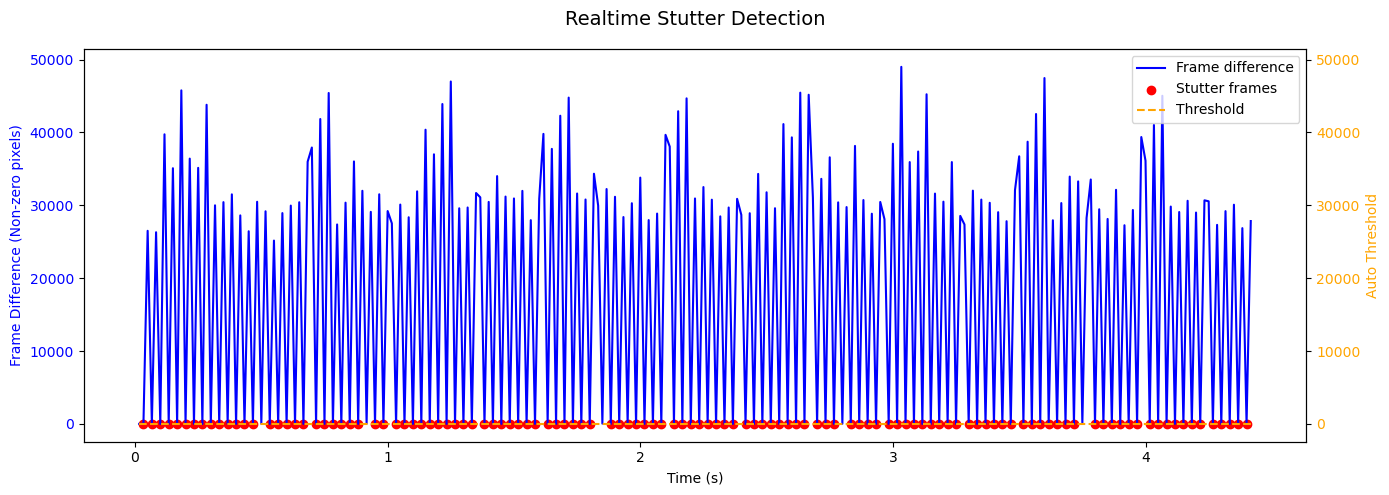

In [30]:
# -----------------------------------------------
# 実行例
# -----------------------------------------------

# Python では、この書き方をすると
# 「このファイルを直接実行したときだけ、以下の処理を動かす」という意味
if __name__ == "__main__":  
    # list_video_devices 関数を呼んで、PCに接続されているカメラを探す
    # 戻り値 devices は [(0, 'Camera 0'), (1, 'Camera 1'), ...] の形式
    devices = list_video_devices()
    if not devices:
        print("利用可能なカメラが見つかりませんでした")
    else:
        # launch_gui 関数で、ユーザーにカメラを選ばせる
        # 戻り値 selected_device は選択されたカメラのデバイス番号
        selected_device = launch_gui(devices)
        if selected_device is not None:
            print(f"選択されたデバイス番号: {selected_device}")
        else:
            print("カメラが選択されませんでした（GUIを閉じました）")

    # 「カメラが選ばれたときだけキャプチャを開始する」 という安全策
    if selected_device is not None: 
        # --- キャプチャ＆逐次カクつき検知実行 ---
        frame_count, output_folder, actual_fps, stutter_files = start_capture_and_detect_worker(
            device_number=selected_device,
            width=720,
            height=480,
            capture_fps=60,
            display_fps=10,
            min_time_diff=0.1,
            max_temp_frames=36000,
            stop_no_diff_sec=300,
            k=2.0
        )

        # CSVログからグラフ化（フレーム画像を読み込む必要なし）
        plot_stutter_csv(output_folder, fps=60)
